# Should change Tkf below

In [1]:
import importlib
import time
import os
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import integrate
from scipy import interpolate

# Should change Tkf below

In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [5]:
tune_name = 'coarse_obs'

save_dir = 'RK_tune'

home = os.path.expanduser('~')
save_dir = os.path.join(
    home,
    'Documents/python_code/multi_loc/notebooks/',
    save_dir)
    
this_path = os.path.join(save_dir, 'Z_GT.npy')
Zgt = np.load(this_path)

this_path = os.path.join(save_dir, 'Z0_ens.npy')
Z0ens = np.load(this_path)

this_path = os.path.join(save_dir, 't_gt.npy')
t_gt = np.load(this_path)

this_path = os.path.join(save_dir, 't_lr.npy')
t_lr = np.load(this_path)

this_path = os.path.join(save_dir, 'run_vars.pkl')
with open(this_path, mode='rb') as f:
    run_vars = pickle.load(f)

In [6]:
for key, value in run_vars.items():
    print(key + ' = ' + str(value))
    exec(key + '=value')

Nz = 960
K = 32
I = 12
F = 15.0
b = 10.0
c = 2.5
alpha = 0.12414383561643835
beta = 0.013746194824961947
coarse = 8
Nez = 20
Nex = 500
dt_rk = 0.004166666666666667
dt_lr = 0.1
dt_gt = 0.0020833333333333333
Tic = 24.0
Tlr = 4000
Tgt = 250


# Should change Tkf below

In [7]:
tune_dir = os.path.join(save_dir, tune_name)
if not os.path.exists(tune_dir):
    os.mkdir(tune_dir)

dt_trial_rk = 0.05/24
dt_kf = 0.5
dt_save = None
Tkf = Tgt     ######## Change this (I forgot) #######
Tspin_index = 200
Tspin = dt_kf * Tspin_index

alpha_range = np.array([0, 0.01, 0.02, 0.04, 0.08], dtype='float')
loc_range = np.array([5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100], dtype='float')


R_sd = 2
everyH = 24
Hz = np.eye(Nz)[::everyH]
Ny = Hz.shape[0]
Rz = np.eye(Ny) * R_sd**2

coarse_obs_dict = {'dt_trial_rk': dt_trial_rk,
                 'dt_kf': dt_kf,
                 'dt_save': dt_save,
                 'Tkf': Tkf,
                 'Tspin': Tspin,
                 'alpha_range': alpha_range,
                 'loc_range': loc_range,
                 'R_sd': R_sd,
                 'everyH': everyH,
                 'Hz': Hz,
                 'Rz': Rz}

this_path = os.path.join(tune_dir, 'coarse_obs_dict.pkl')
with open(this_path, mode='wb') as f:
    pickle.dump(coarse_obs_dict, f)

In [8]:
Nobs = int(Tkf/dt_kf) + 1
t_kf = np.linspace(0, Tkf, Nobs)

Ngt = int(Tgt/dt_gt) + 1
t_gt = np.linspace(0, Tgt, Ngt)
index_Tkf = int(Tkf/dt_gt) + 1

every_t = int(dt_kf/dt_gt)

if not np.allclose(t_kf, t_gt[0:index_Tkf:every_t]):
    print('They do not match')

In [9]:
Zloc = np.arange(Nz)

Zgt_ts = xr.DataArray(Zgt[:, 0:index_Tkf:every_t],
                      dims=('loc', 'time'),
                      coords={'loc': Zloc,
                              'time': t_kf})
Zobs_ts = Zgt[::everyH, 0:index_Tkf:every_t]
Zobs_ts = xr.DataArray(Zobs_ts,
                       dims=('loc', 'time'),
                       coords={'loc': Zloc[::everyH],
                               'time': t_kf})
del Zgt

In [13]:
## Add on 

importlib.reload(assimilate)
importlib.reload(utilities)


rmse_array_f = np.ones([alpha_range.size, loc_range.size]) * np.nan
std_array_f = rmse_array_f.copy()

rmse_array_a = rmse_array_f.copy()
std_array_a = rmse_array_f.copy()

stdrd_dir = os.path.join(tune_dir, 'stdrd_loc')
if not os.path.exists(stdrd_dir):
    os.mkdir(stdrd_dir)
    
alpha_count = 5
this_alpha = 0.12
for loc_count, this_loc in enumerate(loc_range):
    this_folder_name = f'inf_{alpha_count:04}_loc_{loc_count:04}'
    this_dir_name = os.path.join(stdrd_dir, this_folder_name)
    if not os.path.exists(this_dir_name):
        os.mkdir(this_dir_name)
    print('alpha: ', this_alpha, '; loc: ', this_loc)
    print(this_dir_name)

    rho_Zc = np.arange(Nz)
    rho_Zc = np.minimum(np.abs(Nz - rho_Zc)%Nz, rho_Zc)
    rho_Zc = np.exp(-(rho_Zc**2)/(2*this_loc**2))
    rho_Zc = sp.linalg.circulant(rho_Zc)
#         imshow(rho_Zc)

    this_path = os.path.join(this_dir_name, 'rho0z')
    np.save(this_path, this_loc)

    this_path = os.path.join(this_dir_name, 'alpha')
    np.save(this_path, this_alpha)

    cycle_dict = {'Z0ens': Z0ens,
                  'Zobs_ts': Zobs_ts,
                  'Rz': Rz, 'Hz': Hz,
                  'Tkf': Tkf,
                  'dt_kf': dt_kf,
                  'dt_rk': dt_trial_rk,
                  'rho_Z': rho_Zc,
                  'rho0_Z': this_loc,
                  'alpha': this_alpha}
    try:
        returned_dict = assimilate.cycle_KF_LM3_stdrd(**cycle_dict)
        mu_f = returned_dict['mu_f']
        std_f = returned_dict['std_f']

        mu_a = returned_dict['mu_a']
        std_a = returned_dict['std_a']

        this_path = os.path.join(this_dir_name, 'mu_f.nc')
        mu_f.to_netcdf(this_path)

        this_path = os.path.join(this_dir_name, 'std_f.nc')
        std_f.to_netcdf(this_path)

        this_path = os.path.join(this_dir_name, 'mu_a.nc')
        mu_a.to_netcdf(this_path)

        this_path = os.path.join(this_dir_name, 'std_a.nc')
        std_a.to_netcdf(this_path)


        rmse_array_f[alpha_count, loc_count] = (np.sqrt(
            ((mu_f - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
                                      .isel(time=slice(Tspin_index, None)).mean())
        rmse_array_a[alpha_count, loc_count] = (np.sqrt(
            ((mu_a - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
                                      .isel(time=slice(Tspin_index, None)).mean())
        std_array_f[alpha_count, loc_count] = (np.sqrt((std_f**2).mean(axis=0))
                                              .isel(time=slice(Tspin_index, None)).mean())
        std_array_a[alpha_count, loc_count] = (np.sqrt((std_a**2).mean(axis=0))
                                              .isel(time=slice(Tspin_index, None)).mean())
        print('rmse_f: ', rmse_array_f[alpha_count, loc_count])
        print('rmse_a: ', rmse_array_a[alpha_count, loc_count])
    except:
        print(this_dir_name, ' has failed.')

alpha:  0.12 ; loc:  5.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs/stdrd_loc/inf_0005_loc_0000
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs/stdrd_loc/inf_0005_loc_0000  has failed.
alpha:  0.12 ; loc:  10.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs/stdrd_loc/inf_0005_loc_0001
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs/stdrd_loc/inf_0005_loc_0001  has failed.
alpha:  0.12 ; loc:  15.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs/stdrd_loc/inf_0005_loc_0002
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs/stdrd_loc/inf_0005_loc_0002  has failed.
alpha:  0.12 ; loc:  20.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs/stdrd_loc/inf_0005_loc_0003
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs/stdrd_loc/inf_0005_loc_0003  has failed.
alpha:  0.12 ; loc:  30.0
/Us

In [10]:
importlib.reload(assimilate)
importlib.reload(utilities)


rmse_array_f = np.ones([alpha_range.size, loc_range.size]) * np.nan
std_array_f = rmse_array_f.copy()

rmse_array_a = rmse_array_f.copy()
std_array_a = rmse_array_f.copy()

stdrd_dir = os.path.join(tune_dir, 'stdrd_loc')
if not os.path.exists(stdrd_dir):
    os.mkdir(stdrd_dir)
    
for alpha_count, this_alpha in enumerate(alpha_range):
    for loc_count, this_loc in enumerate(loc_range):
        this_folder_name = f'inf_{alpha_count:04}_loc_{loc_count:04}'
        this_dir_name = os.path.join(stdrd_dir, this_folder_name)
        if not os.path.exists(this_dir_name):
            os.mkdir(this_dir_name)
        print('alpha: ', this_alpha, '; loc: ', this_loc)
        print(this_dir_name)

        rho_Zc = np.arange(Nz)
        rho_Zc = np.minimum(np.abs(Nz - rho_Zc)%Nz, rho_Zc)
        rho_Zc = np.exp(-(rho_Zc**2)/(2*this_loc**2))
        rho_Zc = sp.linalg.circulant(rho_Zc)
#         imshow(rho_Zc)
        
        this_path = os.path.join(this_dir_name, 'rho0z')
        np.save(this_path, this_loc)
        
        this_path = os.path.join(this_dir_name, 'alpha')
        np.save(this_path, this_alpha)

        cycle_dict = {'Z0ens': Z0ens,
                      'Zobs_ts': Zobs_ts,
                      'Rz': Rz, 'Hz': Hz,
                      'Tkf': Tkf,
                      'dt_kf': dt_kf,
                      'dt_rk': dt_trial_rk,
                      'rho_Z': rho_Zc,
                      'rho0_Z': this_loc,
                      'alpha': this_alpha}
        try:
            returned_dict = assimilate.cycle_KF_LM3_stdrd(**cycle_dict)
            mu_f = returned_dict['mu_f']
            std_f = returned_dict['std_f']

            mu_a = returned_dict['mu_a']
            std_a = returned_dict['std_a']

            this_path = os.path.join(this_dir_name, 'mu_f.nc')
            mu_f.to_netcdf(this_path)

            this_path = os.path.join(this_dir_name, 'std_f.nc')
            std_f.to_netcdf(this_path)

            this_path = os.path.join(this_dir_name, 'mu_a.nc')
            mu_a.to_netcdf(this_path)

            this_path = os.path.join(this_dir_name, 'std_a.nc')
            std_a.to_netcdf(this_path)


            rmse_array_f[alpha_count, loc_count] = (np.sqrt(
                ((mu_f - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
                                          .isel(time=slice(Tspin_index, None)).mean())
            rmse_array_a[alpha_count, loc_count] = (np.sqrt(
                ((mu_a - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
                                          .isel(time=slice(Tspin_index, None)).mean())
            std_array_f[alpha_count, loc_count] = (np.sqrt((std_f**2).mean(axis=0))
                                                  .isel(time=slice(Tspin_index, None)).mean())
            std_array_a[alpha_count, loc_count] = (np.sqrt((std_a**2).mean(axis=0))
                                                  .isel(time=slice(Tspin_index, None)).mean())
            print('rmse_f: ', rmse_array_f[alpha_count, loc_count])
            print('rmse_a: ', rmse_array_a[alpha_count, loc_count])
        except:
            print(this_dir_name, ' has failed.')

alpha:  0.0 ; loc:  5.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs/stdrd_loc/inf_0000_loc_0000
rmse_f:  2.678710619747747
rmse_a:  2.1539713546872483
alpha:  0.0 ; loc:  10.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs/stdrd_loc/inf_0000_loc_0001
rmse_f:  1.6850713685110303
rmse_a:  1.1455738562311577
alpha:  0.0 ; loc:  15.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs/stdrd_loc/inf_0000_loc_0002
rmse_f:  1.5412763352442083
rmse_a:  0.991578137573073
alpha:  0.0 ; loc:  20.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs/stdrd_loc/inf_0000_loc_0003
rmse_f:  1.5058698562152306
rmse_a:  0.9474288197807796
alpha:  0.0 ; loc:  30.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs/stdrd_loc/inf_0000_loc_0004
rmse_f:  1.421244722558985
rmse_a:  0.8752033295738161
alpha:  0.0 ; loc:  40.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/c

rmse_f:  1.3378958618603738
rmse_a:  0.7818541071461115
alpha:  0.04 ; loc:  80.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs/stdrd_loc/inf_0003_loc_0009
rmse_f:  1.3655371507524192
rmse_a:  0.7933821164033839
alpha:  0.04 ; loc:  90.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs/stdrd_loc/inf_0003_loc_0010
rmse_f:  1.3923820093846049
rmse_a:  0.8156613591328261
alpha:  0.04 ; loc:  100.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs/stdrd_loc/inf_0003_loc_0011
rmse_f:  1.3731576371388068
rmse_a:  0.8027637698749122
alpha:  0.08 ; loc:  5.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs/stdrd_loc/inf_0004_loc_0000
rmse_f:  2.5616299668809637
rmse_a:  2.0237612013634103
alpha:  0.08 ; loc:  10.0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs/stdrd_loc/inf_0004_loc_0001
rmse_f:  1.6588708364591438
rmse_a:  1.1023411241324672
alpha:  0.08 ; loc:  15.

In [11]:
this_path = os.path.join(stdrd_dir, 'rmse_array_f.npy')
np.save(this_path, rmse_array_f)

this_path = os.path.join(stdrd_dir, 'std_array_f.npy')
np.save(this_path, std_array_f)

this_path = os.path.join(stdrd_dir, 'rmse_array_a.npy')
np.save(this_path, rmse_array_a)

this_path = os.path.join(stdrd_dir, 'std_array_a.npy')
np.save(this_path, std_array_a)

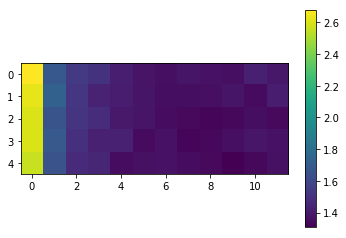

In [12]:
imshow(rmse_array_f)